Data project:

CAPM - financial data

Choose 3 stocks and market (SP-500)
1. Data
- Import stock data from csv/api
- Merge stock data together
- Calculate expected return matrix
- Calculate covariance matrix

2. CAPM Regression
- Calculate stock regression.

![image.png](attachment:image.png)

- What is the market exposure/risk premium (Betas)
- Does CAPM hold? (Is alpha = 0)

3. CAPM: Portfolio
- Find Minimum variance portfolio and Efficient tangent portfolio (Highest sharpe ratio).
- Plot portfolios in volatility-return diagram.



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np


# 1 Data

## 1.1) Importing data

In [2]:
#data = yf.download(["^GSPC", "BTC-USD", "META", "IVN.TO" ], start = "2020-01-01", end = "2024-04-08", interval = "1mo")
#data = data.iloc[:, :2]

data = yf.download(["^GSPC", "NVO", "MSFT", "META"], start = "2019-12-01", end = "2024-04-11", interval = "1mo")
#Hvis vi bare downloader data uden at specificere at det er Adjusted Close, så får vi en masse vi ikke skal bruge
data = data['Adj Close']
data['sp500_returns'] = data['^GSPC'].pct_change() * 100
data["NVO_returns"] = data["NVO"].pct_change() * 100
data["MSFT_returns"] = data["MSFT"].pct_change() * 100
data["META_returns"] = data["META"].pct_change() * 100
data = data.dropna()

print(data.tail())

[*********************100%%**********************]  4 of 4 completed

Ticker            META        MSFT         NVO        ^GSPC  sp500_returns  \
Date                                                                         
2023-12-01  353.584839  375.345886  102.708961  4769.830078       4.422923   
2024-01-01  389.726501  396.846130  113.918091  4845.649902       1.589571   
2024-02-01  489.610535  412.876495  118.912056  5096.270020       5.172064   
2024-03-01  485.579987  420.720001  127.480232  5254.350098       3.101878   
2024-04-01  523.159973  427.929993  125.400002  5199.060059      -1.052272   

Ticker      NVO_returns  MSFT_returns  META_returns  
Date                                                 
2023-12-01     1.580909     -0.556011      8.195018  
2024-01-01    10.913487      5.728115     10.221497  
2024-02-01     4.383821      4.039441     25.629264  
2024-03-01     7.205473      1.899722     -0.823215  
2024-04-01    -1.631806      1.713727      7.739196  


In [3]:
#returns = data.iloc[:, [4,5,6,7]] #betyder alle rækker, og kolonne 4,5,6,7. husk at 0,1,2,3,4,5,6,7
returns = data.loc[:,['NVO_returns', 'MSFT_returns', 'META_returns']]
return_matrix = np.mean(returns, axis=0)
print(return_matrix)
variance_matrix = np.var(returns, axis=0, ddof=1)
# We set the Delta Degrees of Freedom paramter to 1, such that it calculates the sample variance, so it matches the variance in the covariance matrix.
print(variance_matrix)

Ticker
NVO_returns     3.155456
MSFT_returns    2.217667
META_returns    2.608261
dtype: float64
Ticker
NVO_returns      35.962917
MSFT_returns     42.481317
META_returns    154.646741
dtype: float64


In [4]:
cov_matrix = returns.cov()
print(cov_matrix)
print("\n")

print(np.sqrt(cov_matrix))

Ticker        NVO_returns  MSFT_returns  META_returns
Ticker                                               
NVO_returns     35.962917     20.112419     10.276538
MSFT_returns    20.112419     42.481317     43.212099
META_returns    10.276538     43.212099    154.646741


Ticker        NVO_returns  MSFT_returns  META_returns
Ticker                                               
NVO_returns      5.996909      4.484687      3.205704
MSFT_returns     4.484687      6.517769      6.573591
META_returns     3.205704      6.573591     12.435704


## 2 Portfolios

In [5]:
# Define portfolio function, which returns ER and Volatility for any portfolio weight x
def portfolio(return_matrix, cov_matrix, w1,w2):
    W = pd.DataFrame([w1,w2, 1-w1-w2], index=['NVO_returns','MSFT_returns','META_returns'])
    tW = W.transpose()
    var = tW.dot(cov_matrix).dot(W)
    sd = np.sqrt(var)[0][0]

    e_r = tW.dot(return_matrix)[0]

   # print(tW)
   #print(W)
    #print(var)
    #print(sd)
    return e_r, sd



In [6]:
er, sd = portfolio(return_matrix, cov_matrix, 0,0)

print(f'Expected return = {er:.3f}, Volatility (standard deviation) = {sd:.3f}')

Expected return = 2.608, Volatility (standard deviation) = 12.436


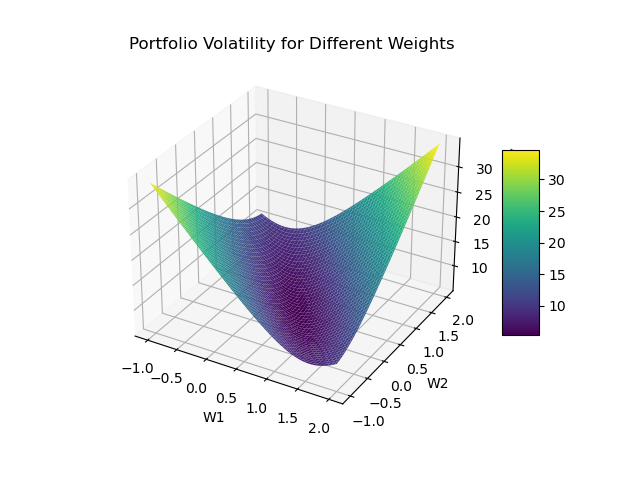

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib widget

# Define the function - Ensure your portfolio function is defined

# Generate the values for w1 and w2
w1_values = np.linspace(-1, 2, 100)  # Smaller number for simplicity
w2_values = np.linspace(-1, 2, 100)  # Smaller number for simplicity

# Create meshgrid for w1 and w2
W1, W2 = np.meshgrid(w1_values, w2_values)

# Initialize an array to hold the function values
function_values = np.zeros(W1.shape)

# Calculate the function values for each (w1, w2) pair
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w1 = W1[i, j]
        w2 = W2[i, j]
        w3 = 1 - w1 - w2  # Ensure the sum of weights is 1
        # Adjust the line below if your portfolio function expects a different format
        function_values[i, j] = portfolio(return_matrix, cov_matrix, w1, w2)[1]

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(W1, W2, function_values, cmap='viridis')

# Add labels and title
ax.set_xlabel('W1')
ax.set_ylabel('W2')
ax.set_zlabel('Portfolio Volatility')
plt.title('Portfolio Volatility for Different Weights')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


# 2.1 Minimum Variance Portfolio

In [8]:
def mvp(return_matrix, cov_matrix, N):
    N = N
    w1_vec = np.linspace(-1, 2, N)
    w2_vec = np.linspace(-1, 2, N)
    vol_best = np.inf
    w1_best = 0
    w2_best = 0
    for w1 in w1_vec:
        for w2 in w2_vec: 
            vol = portfolio(return_matrix, cov_matrix, w1, w2)[1]
            if vol < vol_best:
                vol_best = vol
                w1_best = w1
                w2_best = w2
    return w1_best, w2_best

w1_min, w2_min = mvp(return_matrix, cov_matrix, 100)

print(f'Minimum variance weights: w1 = {w1_min:.3f}, w2 = {w2_min:.3f}, w3 = {1-w1_min-w2_min:.3f}')

#print(f'Minimum variance weights: w1 = {w_min:.3f}, w2 = {1 - w_min:.3f}')

Minimum variance weights: w1 = 0.606, w2 = 0.333, w3 = 0.061


In [9]:
mvp = portfolio(return_matrix, cov_matrix, 0.091, 0.576)
print(f'MVP return = {mvp[0]:.3f}, MVP volatility = {mvp[1]:.3f}')

MVP return = 2.433, MVP volatility = 7.131


# 2.2 Efficient Tangent Portfolio

In [10]:
def sharpe_ratio(w1, w2, portfolio, rf = 0):
    '''Calculate the sharpe ratio for any portfolio'''

    rf = rf # Risk free rate
    e_r, sd = portfolio(return_matrix, cov_matrix, w1, w2) # Expected return and volatility

    sharpe = (e_r - rf)/sd
    return sharpe

In [11]:
def etp_w(N, portfolio):
    '''Calculates Efficient Tangent Portfolio by finding the highest Sharpe ratio'''

    # Create linear weight vector
    N = N
    w1_vec = np.linspace(-1, 2, N)
    w2_vec = np.linspace(-1, 2, N)

    # Initial best volatility and weight
    sharpe_best = -np.inf
    w1_best = 0
    w2_best = 0

    # Loops over all weight and saves the weight if the volatility is lower than before
    for w1 in w1_vec:
        for w2 in w2_vec:
            sharpe = sharpe_ratio(w1, w2, portfolio)
            if sharpe > sharpe_best:
                sharpe_best = sharpe
                w1_best = w1
                w2_best = w2
    return w1_best, w2_best

In [12]:
w1_etp, w2_etp = etp_w(100, portfolio)
print(f'Efficient tangent portfolio weights: w1 = {w1_etp:.3f}, w2 = {w2_etp:.3f} and w3 = {1-w1_etp-w2_etp:.3f}\n')


Efficient tangent portfolio weights: w1 = 0.879, w2 = 0.000 and w3 = 0.121



In [13]:
etp = portfolio(return_matrix, cov_matrix, w1_etp, w2_etp)
print(f'ETP return = {etp[0]:.3f}, ETP volatility = {etp[1]:.3f}')

ETP return = 3.089, ETP volatility = 5.678


# Plot mangler

In [14]:
def plot_sharp(portfolio):
    '''Plots Sharpe ratios and the efficient tangent portfolio'''

    # Generate the values for x, y, and z
    w1_values = np.linspace(-1, 2, 100)  # Varying values for the third input
    w2_values = np.linspace(-1, 2, 100)  # Varying values for the third input

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the values of the function for each z value
    function_values = []

    for w1 in w1_values:
        for w2 in w2_values:
            # Calculate the function values
            function_values.append(sharpe_ratio(w1, w2, portfolio)) 
    
    # Calculate ETP
    w_etp = etp_w(100, portfolio)

    ax.plot(w1_values, function_values, label = "sharpe ratio")
    ax.scatter(w_etp, sharpe_ratio(w_etp, portfolio), c = "red", label = "efficient tangent portfolio")

    # Add labels and a legend
    ax.set_xlabel('weight')
    ax.set_ylabel('Sharpe ratio')
    ax.legend()

    ax.set_xlim(-1, 2)
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (10000,)

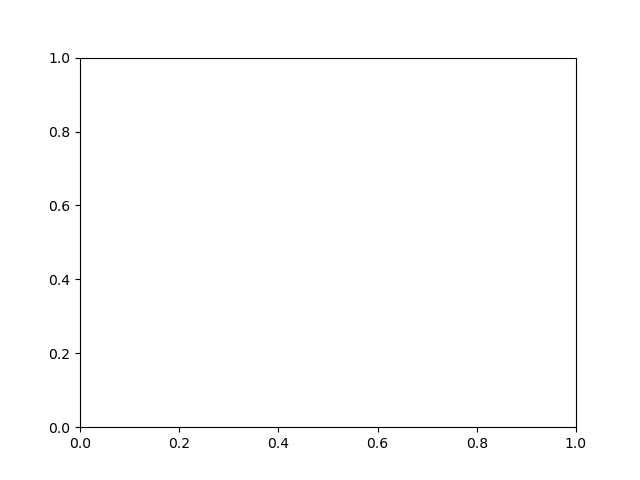

In [15]:
plot_sharp(portfolio)

## 2.3 Efficient market frontier

In [16]:
# Weights for the MVP and ETP
mvp_weights = pd.DataFrame([w1_min, w2_min, 1 - w1_min - w2_min])
etp_weights = pd.DataFrame([w1_etp, w2_etp, 1 - w1_etp - w2_etp])

# Creating y_vec and lin_vec to store linear combinations
y_vec = np.linspace(-3, 3, 100)
lin_vec = []

for y in y_vec:
    linear = y*mvp_weights + (1-y)*etp_weights
    lin_vec.append(linear[0][0])

In [17]:
def plot_capm(mvp, etp, lin_vec, portfolio):
    '''Plots the efficient frontier and the capital market line'''
    fig, ax = plt.subplots()

    # Empty vector to store frontier
    frontier = []

    for l in lin_vec:
        # Calculate the function values
        frontier.append(portfolio(return_matrix, cov_matrix, w1, w2)) 
        
    return_values, vol_values = zip(*frontier)

    rf = 0
    point_rf = [0, rf]
    point_etp = [etp[1], etp[0]]

    # Compute the equation of the line passing through the two points
    # y = mx + c, where m is the slope and c is the y-intercept
    slope = (point_etp[1] - point_rf[1]) / (point_etp[0] - point_rf[0])
    y_intercept = point_rf[1] - slope * point_rf[0]

    # Generate x values for the line
    x_values = np.linspace(0, 10, 100)
    # Compute corresponding y values
    y_values = slope * x_values + y_intercept

    # Plot the points and the line passing through them
    plt.plot(x_values, y_values, label='Capital market line', linewidth = 0.5, color = "black")


    ax.plot(vol_values, return_values, label = "efficient frontier", linewidth = 0.5, color = "blue")
    #ax.scatter(0, rf, label = "risk free")
    ax.scatter(mvp[1], mvp[0], c = "green", label = "minimum variance portfolio")
    ax.scatter(etp[1], etp[0], c = "red", label = "efficient tangent portfolio")

    # Add labels and a legend
    ax.set_xlabel('volatility')
    ax.set_ylabel('return')
    ax.legend()

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    plt.show()

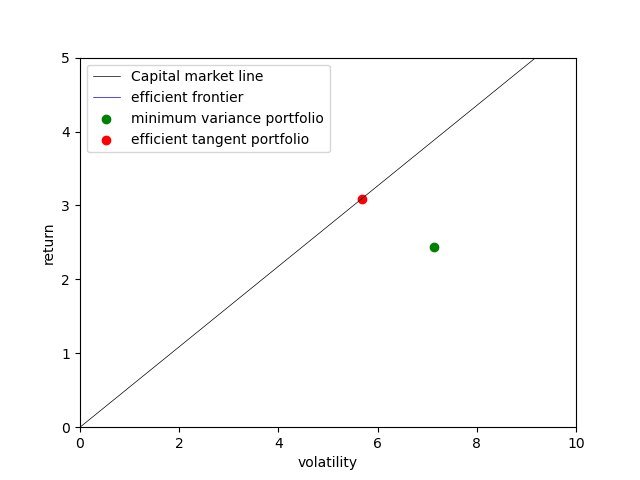

In [18]:
plot_capm(mvp, etp, lin_vec, portfolio)

# 3 Market regression

## 3.1 Beregn CAPM prædiktion

- Indhent datasæt Fama-French.xlsx
- Merge returns fra yahoo og Fama-French datasæt på datoerne
- Beregn "stock_return" - rf 
- Regresser r - rf = Mkt - rf

Hvor stor er beta, har de mere eller mindre risiko end markedet?

In [23]:
df = pd.read_excel('Fama-French.xlsx') # Datasæt med returns for markedsporteføljen og risk free bonds
df.columns = ['Date'] + list(df.columns[1:])
df.set_index("Date", inplace=True)
print(df.tail())

        Mkt-RF    RF
Date                
202310   -3.19  0.47
202311    8.84  0.44
202312    4.87  0.43
202401    0.71  0.47
202402    5.06  0.42


In [24]:
#print(data.index)
#print(df.index)


DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
Int64Index([19

In [27]:
########Merging the datasets data and df#########
# Convert the index in `df` from numeric YYYYMM to datetime format
df.index = pd.to_datetime(df.index, format='%Y%m')

# Merge the dataframes on the Date index
merged_data = data.merge(df, left_index=True, right_index=True, how='inner')

# Print the first few rows of the merged dataframe to verify
print(merged_data.head())

                  META        MSFT        NVO        ^GSPC  sp500_returns  \
Date                                                                        
2020-01-01  201.695999  163.737305  28.578434  3225.520020      -0.162809   
2020-02-01  192.266006  155.830826  27.309952  2954.219971      -8.411048   
2020-03-01  166.623215  152.109161  28.282452  2584.590088     -12.511928   
2020-04-01  204.493042  172.845581  29.752953  2912.429932      12.684404   
2020-05-01  224.851425  176.742126  30.979155  3044.310059       4.528182   

            NVO_returns  MSFT_returns  META_returns  Mkt-RF    RF  
Date                                                               
2020-01-01     5.096754      7.945496     -1.627282   -0.11  0.13  
2020-02-01    -4.438599     -4.828758     -4.675349   -8.13  0.12  
2020-03-01     3.560972     -2.388272    -13.337143  -13.39  0.13  
2020-04-01     5.199340     13.632591     22.727822   13.65  0.00  
2020-05-01     4.121278      2.254351      9.955538 

In [39]:
return_columns = ['META_returns', 'MSFT_returns', 'NVO_returns', 'sp500_returns']

for column in return_columns:
    merged_data[column + '-rf'] = merged_data[column] - merged_data['RF']


# Print the first few rows to verify the adjusted returns
print(merged_data[[col + '-rf' for col in return_columns]].head())

            META_returns-rf  MSFT_returns-rf  NVO_returns-rf  sp500_returns-rf
Date                                                                          
2020-01-01        -1.757282         7.815496        4.966754         -0.292809
2020-02-01        -4.795349        -4.948758       -4.558599         -8.531048
2020-03-01       -13.467143        -2.518272        3.430972        -12.641928
2020-04-01        22.727822        13.632591        5.199340         12.684404
2020-05-01         9.945538         2.244351        4.111278          4.518182


In [40]:
import statsmodels.api as sm

# List of stock return columns to regress
stock_returns = ['META_returns-rf', 'MSFT_returns-rf', 'NVO_returns-rf', 'sp500_returns-rf']

# Prepare the explanatory variable, adding a constant for the intercept
X = sm.add_constant(merged_data['Mkt-RF'])  # Explanatory variable (market excess returns)

# Loop through each stock return column and perform regression
results = {}
for return_col in stock_returns:
    # Prepare the dependent variable
    y = merged_data[return_col]  # Dependent variable (stock excess returns)

    # Fit the regression model
    model = sm.OLS(y, X, missing='drop')  # OLS regression, excluding NaN values
    results[return_col] = model.fit()

    # Print the summary of the regression results
    print(f"Regression Results for {return_col}:\n")
    print(results[return_col].summary())
    print("\n\n")


Regression Results for META_returns-rf:

                            OLS Regression Results                            
Dep. Variable:        META_returns-rf   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     16.08
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           0.000211
Time:                        15:00:22   Log-Likelihood:                -189.91
No. Observations:                  50   AIC:                             383.8
Df Residuals:                      48   BIC:                             387.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [38]:
beta_values = {}

for key, result in results.items():
    beta_values[key] = result.params['Mkt-RF']

beta_table = pd.DataFrame(list(beta_values.items()), columns=['Stock', 'Beta'])

print(beta_table)

              Stock      Beta
0   META_returns-rf  1.088251
1   MSFT_returns-rf  0.815596
2    NVO_returns-rf  0.349883
3  sp500_returns-rf  0.959012


META har højere risiko end markedet, MSFT har og NVO har lavere.
Ifølge teorien vil en aktie med højere systematisk risiko og høj kovarians med markedet (højere beta) have større afkast. Dette er ikke tilfældet; Novo Nordisk har lavest systematisk risiko og også større afkast end de andre aktier.
